<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_FLAX_NNX_save_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

In [2]:
#!pip install orbax-checkpoint==0.9.1

In [3]:
import jax
import flax
import orbax.checkpoint as ocp

In [25]:
print(jax.__version__, flax.__version__, ocp.__version__)
#0.4.33 0.10.3 0.6.4 on Colab 25 Fev 0k
#0.5.0 0.10.3 0.11.5 on Jean Zay 25 Fev Ok

0.4.33 0.10.3 0.6.4


In [5]:
jax.random.PRNGKey(0)

Array([0, 0], dtype=uint32)

In [6]:
import jax.numpy as jnp

In [7]:
from functools import partial

import numpy as np
num_devices = jax.device_count()
num_devices # 1

1

In [8]:
args = {
    'x_dim': 2,
    'seed': 2025,
}
args['num_blobs'] = 4
args['x_lim'] = 1

# Set the parallel batch size.
args['batch_size'] = num_devices * 512 if num_devices > 1 else  512
args['epochs'] = 1500  # min: 500. More <=> less samples between the blobs...
args['batch_size_p'] = args['batch_size'] //  num_devices

args['sigma_max'] = 15.0

In [9]:
import optax

from flax import nnx
from flax.training import train_state

from typing import Any, Callable, Sequence, Optional, Tuple
PRNGKey = jnp.ndarray

# Dataset

In [10]:
def make_dataset_gaussian_blobs(
    seed: int,
    batch_size: int = 1,
    num_blobs: int = 8,
    r: float = 1.0,
    SCALE: float = 0.1
):
    key = jax.random.PRNGKey(seed)
    offset = 0  # jnp.pi / num_blobs
    thetas = jnp.linspace(offset, 2 * jnp.pi + offset, num_blobs, endpoint=False)
    x = r * jnp.cos(thetas)
    y = r * jnp.sin(thetas)
    loc = jnp.stack([x, y], axis=-1)

    kay, key1 = jax.random.split(key,2)
    iblob = jax.random.randint(key1,minval=0, maxval=num_blobs, shape=(batch_size,))
    keys = jax.random.split(key,batch_size)
    dataGen = jax.vmap(lambda x: jax.random.multivariate_normal(keys[x],
            mean=loc[iblob[x]],
            cov=SCALE**2*jnp.array([[1,0],[0,1]]), shape=(1,)))

    data = dataGen(jnp.arange(batch_size))
    data = data.squeeze()

    return data/(2*jnp.max(jnp.abs(data))) + jnp.ones((batch_size,2))*0.5


In [11]:
dataset_size = 100_000
batches_in_epoch = dataset_size // args['batch_size']
dataset_size = batches_in_epoch * args['batch_size']

print(dataset_size, batches_in_epoch)

99840 195


In [12]:
X_train= make_dataset_gaussian_blobs(seed=args['seed'],num_blobs=args['num_blobs'],
                                     batch_size=dataset_size)
xlim, ylim = [0,args['x_lim'] ], [0,args['x_lim'] ]

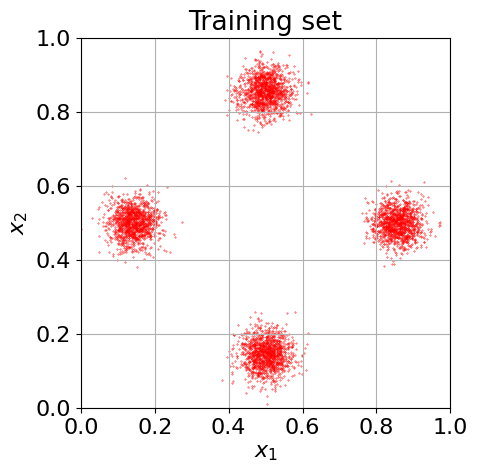

In [13]:
plt.scatter(X_train[:5000, 0], X_train[:5000, 1], s=0.1, color='red',label='Train')
plt.title("Training set")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.grid()

In [14]:
import itertools
data_gen = itertools.cycle(jnp.array(jnp.array_split(jax.random.permutation(jax.random.PRNGKey(42),X_train), batches_in_epoch )))

# ScoreNet simple architecture

In [15]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  return jnp.sqrt((sigma**(2 * t) - 1.) / 2. / jnp.log(sigma))

marginal_prob_std_fn = partial(marginal_prob_std, sigma=args['sigma_max'])

In [16]:
class GaussianFourierProjection(nnx.Module):
  """Gaussian random features for encoding time steps."""
  #embed_dim: int
  #scale: float = 30.

  def __init__(self, embed_dim: int, scale: float, *, rngs: nnx.Rngs):
    key = rngs.params()
    dout = embed_dim // 2
    self.W = nnx.Variable(jax.random.normal(key, (dout,))  *  scale)

  def __call__(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * jnp.pi
    return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)

class ScoreNet(nnx.Module):
  channels: Tuple[int] =  (32, 64, 128, 256)
  embed_dim: int = 256
  scale: float = 30.

  def __init__(self, marginal_prob_std:Any, din_t:int, rngs: nnx.Rngs):
    self.act = nnx.swish
    self.marginal_prob_std = marginal_prob_std
    #time embedding
    self.embed = GaussianFourierProjection(embed_dim=self.embed_dim,
                                           scale=self.scale,
                                           rngs=rngs)
    self.LayerEmb = nnx.Linear(self.embed_dim, self.embed_dim, rngs=rngs)
    #encoding part
    self.Layer1  = nnx.Linear(args['x_dim'],self.channels[0],use_bias=False, rngs=rngs)
    self.Layer1e = nnx.Linear(self.embed_dim,self.channels[0], rngs=rngs)
    self.Norm1   = nnx.GroupNorm(self.channels[0],num_groups=4, rngs=rngs)

    self.Layer2  = nnx.Linear(self.channels[0],self.channels[1],use_bias=False, rngs=rngs)
    self.Layer2e = nnx.Linear(self.embed_dim,self.channels[1], rngs=rngs)
    self.Norm2   = nnx.GroupNorm(self.channels[1], rngs=rngs) # num_groups=32 by default

    self.Layer3  = nnx.Linear(self.channels[1],self.channels[2],use_bias=False, rngs=rngs)
    self.Layer3e = nnx.Linear(self.embed_dim,self.channels[2], rngs=rngs)
    self.Norm3   = nnx.GroupNorm(self.channels[2], rngs=rngs) # num_groups=32 by default

    self.Layer4  = nnx.Linear(self.channels[2],self.channels[3],use_bias=False, rngs=rngs)
    self.Layer4e = nnx.Linear(self.embed_dim,self.channels[3], rngs=rngs)
    self.Norm4   = nnx.GroupNorm(self.channels[3], rngs=rngs) # num_groups=32 by default

    #decoding part
    self.Layer5  = nnx.Linear(self.channels[3],self.channels[2],use_bias=False, rngs=rngs)
    self.Layer5e = nnx.Linear(self.embed_dim,self.channels[2], rngs=rngs)
    self.Norm5   = nnx.GroupNorm(self.channels[2], rngs=rngs) # num_groups=32 by default

    self.Layer6  = nnx.Linear(2*self.channels[2],self.channels[1],use_bias=False, rngs=rngs)
    self.Layer6e = nnx.Linear(self.embed_dim,self.channels[1], rngs=rngs)
    self.Norm6   = nnx.GroupNorm(self.channels[1], rngs=rngs) # num_groups=32 by default

    self.Layer7  = nnx.Linear(2*self.channels[1],self.channels[0],use_bias=False, rngs=rngs)
    self.Layer7e = nnx.Linear(self.embed_dim,self.channels[0], rngs=rngs)
    self.Norm7   = nnx.GroupNorm(self.channels[0], rngs=rngs) # num_groups=32 by default

    self.Layer7  = nnx.Linear(2*self.channels[1],self.channels[0],use_bias=False, rngs=rngs)
    self.Layer7e = nnx.Linear(self.embed_dim,self.channels[0], rngs=rngs)
    self.Norm7   = nnx.GroupNorm(self.channels[0], rngs=rngs) # num_groups=32 by default

    self.Layer8  = nnx.Linear(2*self.channels[0],args['x_dim'], rngs=rngs)


  def __call__ (self,x,t):
    # time embding
    embed = self.act(self.LayerEmb(self.embed(t)))

    # encoding
    h1 = self.Layer1(x)
    h1 += self.Layer1e(embed)
    h1 = self.Norm1(h1)
    h1 = self.act(h1)

    h2 = self.Layer2(h1)
    h2 += self.Layer2e(embed)
    h2 = self.Norm2(h2)
    h2 = self.act(h2)

    h3 = self.Layer3(h2)
    h3 += self.Layer3e(embed)
    h3 = self.Norm3(h3)
    h3 = self.act(h3)

    h4 = self.Layer4(h3)
    h4 += self.Layer4e(embed)
    h4 = self.Norm4(h4)
    h4 = self.act(h4)

    # decondig
    h = self.Layer5(h4)
    h += self.Layer5e(embed)
    h = self.Norm5(h)
    h = self.act(h)

    h = self.Layer6(jnp.concatenate([h, h3], axis=-1))
    h += self.Layer6e(embed)
    h = self.Norm6(h)
    h = self.act(h)

    h = self.Layer7(jnp.concatenate([h, h2], axis=-1))
    h += self.Layer7e(embed)
    h = self.Norm7(h)
    h = self.act(h)

    h = self.Layer8(jnp.concatenate([h, h1], axis=-1))

    # normalisation
    h = h / self.marginal_prob_std(t)[:, None]
    return h

# Training
restart from here if you want to change training parameters

[note 1] This use the [fax #4224](https://github.com/google/flax/discussions/4224)

In [17]:
import os
import shutil
path = os.getcwd()

In [18]:
import orbax.checkpoint as ocp

# Create the checkpoint manager
ckpt_dir = f"{path}/tmp"
ckpt_dir = ocp.test_utils.erase_and_create_empty(ckpt_dir)

options = ocp.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    # other options
)
mngr = ocp.CheckpointManager(
    ckpt_dir,
    options=options,
)


In [20]:
#@nnx.jit  slow see
#def train_step(model: ScoreNet,
#                optimizer: nnx.Optimizer,
#                x: jnp.ndarray,
#                key: PRNGKey):
@jax.jit
def train_step(graphdef, state, x, key):

  model, optimizer = nnx.merge(graphdef, state)   # see [note 1]

  key, key_std, key_noise = jax.random.split(key,3)
  random_t = jax.random.uniform(key_std, (x.shape[0],), minval=1e-5, maxval=1.)
  std = marginal_prob_std_fn(random_t)
  z = jax.random.normal(key_noise, x.shape)
  perturbed_x = x + z * std[:,None]

  def loss_fn(model: ScoreNet):
    score = model(perturbed_x, random_t)
    loss = jnp.mean(jnp.sum((score * std[:, None] + z)**2, axis=1))
    return loss

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)

  #see [note 1]
  _, state = nnx.split((model, optimizer))
  return state, loss
  #return loss

In [21]:
jax.random.PRNGKey(0)

Array([0, 0], dtype=uint32)

In [22]:
key = jax.random.PRNGKey(seed=2025)
key, key_scorenet = jax.random.split(key, 2)

total_steps = (args['epochs']+1) * batches_in_epoch
print(total_steps)
schedule_fn = optax.piecewise_constant_schedule(init_value=1e-3,
        boundaries_and_scales={int(total_steps*0.33):0.1,
                               int(total_steps*0.66):0.1})

model = ScoreNet(marginal_prob_std_fn,din_t=1,rngs=nnx.Rngs(args['seed']))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=schedule_fn))# implicitly does not upate W variables

graphdef, state = nnx.split((model, optimizer))  # see [note1]


292695


In [23]:
from IPython.display import clear_output
import orbax

In [24]:
info_losses=[]
loss_best = jnp.inf

eval_every = 10

for epoch in range(1, args['epochs'] + 1):
    loss_mean = 0.
    for batch in range(batches_in_epoch):
      # Generate RNG keys for denoiser
      key, key_scorenet = jax.random.split(key, 2)
      #key_scorenet = shard_prng_key(key_scorenet)

      # Shard the data to possible devices.
      batch_data = next(data_gen)
      # Take a step with the denoiser.
      state, loss = train_step(graphdef, state, batch_data, key_scorenet)  #see [note 1]
      #loss =  train_step(model, optimizer,
      #                  batch_data, key_scorenet)

      loss_mean += loss

    loss_mean = loss_mean/batches_in_epoch
    info_losses.append(loss_mean)
    #save best
    if loss_mean < loss_best:
      loss_best = loss_mean
      epoch_best = epoch
      nnx.update((model, optimizer), state) #see note1
      _, best_state = nnx.split(model)
      mngr.save(epoch_best, args=ocp.args.StandardSave(best_state))

    if epoch > 0 and (epoch % eval_every == 0 or epoch == args['epochs']):
        clear_output(wait=True)
        print(f"Epoch {epoch}/{args['epochs']}: loss = {loss_mean:.5f}")
#        clear_output(wait=True)
#        # Plot loss and accuracy in subplots
#        plt.plot(info_losses,label='Loss')
#        plt.scatter(epoch_best,loss_best,s=10,c='r',label='best')
#        plt.yscale('log')
#        plt.legend();
#        plt.show()


Epoch 1500/1500: loss = 0.17366


In [26]:
mngr.wait_until_finished()

# Plot

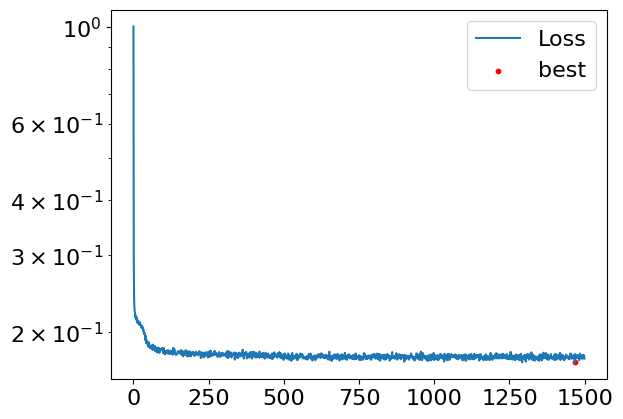

In [27]:
import numpy as np

info_losses = np.array(info_losses)
plt.plot(info_losses,label='Loss')
plt.scatter(epoch_best,loss_best,s=10,c='r',label='best')
plt.yscale('log')
#plt.xlim([0,10])
#plt.ylim([info_den_losses.min()/2,1])
plt.legend();

# Sampling

In [28]:
def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t
diffusion_coeff_fn = partial(diffusion_coeff, sigma=args['sigma_max'])

In [29]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(rng,
                model,   # model
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                z=None,
                eps=1e-5):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    rng: A JAX random state.
    score_model: A `flax.linen.Module` object  that represents architecture
      of the score-based model.
    params: A dictionary that contains model parameters.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """

  time_shape = (batch_size,)
  sample_shape = (*time_shape, args['x_dim'])

  # Create the latent code
  if z is None:
    rng, step_rng = jax.random.split(rng)
    z = jax.random.normal(step_rng, sample_shape)
    init_x = z * marginal_prob_std(1.)
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = jnp.asarray(sample, dtype=jnp.float32).reshape(sample_shape)
    time_steps = jnp.asarray(time_steps).reshape(time_shape)

    #score, (graphdef, new_state) = state.apply_fn(
    #  state.params,
    #  state.other_variables
    #)( sample, time_steps)
    score = model(sample, time_steps)

    return np.asarray(score).reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones(time_shape) * t
    g = diffusion_coeff(t)
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), np.asarray(init_x).reshape(-1),
                            rtol=rtol, atol=atol, method='RK45', max_step=200)
  print(f"Number of function evaluations: {res.nfev}")
  x = jnp.asarray(res.y[:, -1]).reshape(shape)

  return x

In [30]:
#model = ScoreNet(marginal_prob_std_fn,din_t=1,rngs=nnx.Rngs(args['seed']))
#optimizer = nnx.Optimizer(model, optax.adamw(learning_rate=schedule_fn))# implicitly does not upate W variables
#nnx.update((model, optimizer), best_state)
# Restore the checkpoint back to its `nnx.State` structure - need an abstract reference.

options = ocp.CheckpointManagerOptions(
    read_only=True,
    create=False,
)

ckpt_dir = f"{path}/tmp"

mngr = ocp.CheckpointManager(
    ckpt_dir,
    options=options,
)



In [32]:
ocp.__version__

'0.6.4'

In [41]:
abstract_model = nnx.eval_shape(lambda: ScoreNet(marginal_prob_std_fn,din_t=1,rngs=nnx.Rngs(0)))
graphdef, abstract_state = nnx.split(abstract_model)

epoch_best= mngr.latest_step()

if ocp.__version__ == '0.6.4':
  state_restored = mngr.restore(epoch_best,  args=ocp.args.StandardSave(abstract_state)) # ocp 0.6.4
elif ocp.__version__ == '0.11.5':
  state_restored = mngr.restore(epoch_best, items=abstract_state)
else:
  state_restored= None
  print("HELP! do not know how to proceed yet")


/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [42]:
model = nnx.merge(graphdef, state_restored)

In [39]:
sample_batch_size = 1_024
sampler = ode_sampler
rng = jax.random.PRNGKey(0)

## Generate samples
rng, step_rng = jax.random.split(rng)
samples = sampler(rng,
                  model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size)

Number of function evaluations: 254


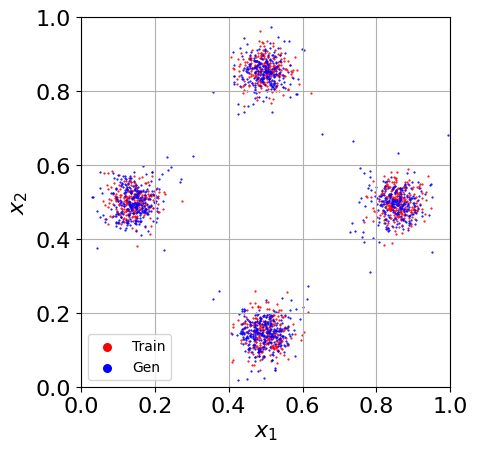

In [40]:
plt.scatter(X_train[:samples.shape[0], 0], X_train[:samples.shape[0], 1], s=0.3, color='red',label='Train')
plt.scatter(samples[:,0],samples[:,1],s=0.3,color='blue',label='Gen')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.grid()
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
